In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, models, optimizers
from tensorflow.keras.layers import TimeDistributed, Conv2D, Flatten, Dense, LSTM, ConvLSTM2D, MaxPool2D, Dropout, Conv1D
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
tf.compat.v1.enable_eager_execution()

In [5]:
inputs_train = np.load("inputs_train.npy")
inputs_test = np.load("inputs_test.npy")

In [6]:
inputs_train = np.transpose(inputs_train, (0, 2,3,1))
inputs_test = np.transpose(inputs_test, (0, 2,3,1))

In [7]:
inputs_train = inputs_train.reshape(inputs_train.shape[:2] + (inputs_train.shape[2]*inputs_train.shape[3],))
inputs_test = inputs_test.reshape(inputs_test.shape[:2] + (inputs_test.shape[2]*inputs_test.shape[3],))

In [8]:
train = pd.read_csv('train_timeframes.csv').iloc[59:]
test = pd.read_csv('test_timeframes.csv').iloc[59:]

In [9]:
df = [train, test]

In [10]:
img = inputs_train[0,:,:]

In [11]:
inputs_train.shape, train.shape

((73695, 60, 20), (73695, 23))

In [12]:
inputs_test.shape, test.shape

((24365, 60, 20), (24365, 23))

In [13]:
idx = 0
batch_size = 32
stop_limit = 0.004
price_limit = 0.004
margin_size = 50
time_limit = 60

In [14]:
model = models.Sequential()
# model.add(LSTM(64, input_shape = img.shape, return_sequences=True, dropout=0.2))
model.add(LSTM(32, input_shape = img.shape, dropout=0.2))
# model.add(LSTM(32, dropout=0.2))
model.add(Dense(3, activation = "sigmoid"))

In [22]:
model = tf.keras.models.load_model('sharpe_model/', compile=False)

In [15]:
# model = models.Sequential()

# model.add(Conv2D(32, (5, 1),padding ='Same', activation='relu', input_shape = img.shape))
# model.add(Conv2D(32, (5, 1),padding = 'Same', activation ='relu'))
# model.add(MaxPool2D((2, 1)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64,(3, 1),padding = 'Same', activation ='relu'))
# model.add(Conv2D(64, (3, 1),padding = 'Same', activation ='relu'))
# model.add(MaxPool2D(pool_size=(2, 1), strides=(2, 1)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(256, activation = "relu"))
# model.add(Dropout(0.5))
# model.add(Dense(3, activation = "sigmoid"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                6784      
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 6,883
Trainable params: 6,883
Non-trainable params: 0
_________________________________________________________________


In [24]:
def custom_loss_wrapper(idx, stop_limit, price_limit, margin_size, time_limit):    
    def custom_loss(y_true, y_pred):
#         print()
        margin = ((y_pred[:,:1] - 0.5) * 2)
        margin *= margin_size
        direction = tf.sign(margin)
        stop_loss = y_pred[:,1:2] * direction * -1 * stop_limit
        price_target = y_pred[:,2:3] * direction * 1 * price_limit
        
        idx = y_true[0][1].numpy()
        df_name = y_true[0][0].numpy()
        batch_size = y_pred.shape[0]
        closes = []
        spread = []
        i = tf.constant(0)
        while_condition = lambda i: tf.less(i, tf.constant(batch_size))
        def body(i):
            closes.append(df[df_name].iloc[int(idx+i.numpy()):int(idx+i.numpy()+time_limit)]['close_1min'].tolist())
            spread.append(df[df_name].iloc[int(idx+i.numpy()):int(idx+i.numpy()+time_limit)]['spread'].tolist())
            return [tf.add(i, 1)]
        r = tf.while_loop(while_condition, body, [i], parallel_iterations=batch_size, swap_memory=True)
        closes = tf.convert_to_tensor(closes)
        spread = tf.convert_to_tensor(spread)
        close1 = closes[:,:1]
        close2 = tf.zeros_like(closes[:,:1])
        lower_bound = tf.minimum(stop_loss, price_target)
        upper_bound = tf.maximum(stop_loss, price_target)
        i = tf.constant(0)
        def while_condition(i, close2): 
            return tf.less(i, tf.constant(closes.shape[1]))
        def body(i, close2):
            diff = (closes[:,i:i+1] - closes[:,:1]) * direction
            cond = tf.logical_or(tf.less(diff, lower_bound), tf.greater(diff, upper_bound))
            close2 = tf.where(tf.logical_and(tf.equal(close2, 0), cond), closes[:,i:i+1], close2)
            return [tf.add(i, 1), close2]
        r = tf.while_loop(while_condition, body, [i, close2], parallel_iterations=closes.shape[1], swap_memory=True)
            
        close2 = tf.where(tf.equal(close2, 0), closes[:,-1:], close2)

        diff = close2 - close1
        profit = 100 * (margin * (diff - (spread*direction))) /  close1
        sharpe = (252 ** 0.5) * tf.reduce_mean(profit) / tf.math.reduce_std(profit)
        return -sharpe
    return custom_loss

In [33]:
def get_profit(data, y_preds, margin_lower_limit=0):
    idx = 0
    profits = []
    while idx < len(y_preds) - 1:
        margin = ((y_preds[idx][0] - 0.5) * 2)
        margin *= margin_size
        if abs(margin) < margin_lower_limit:
            idx += 1
        else:
            direction = np.sign(margin)
            stop_loss = y_preds[idx][1] * direction * -1 * stop_limit
            price_target = y_preds[idx][2] * direction * 1 * price_limit

            start_idx = idx
            close1 =  data.iloc[idx]['close_1min']
            spread = data.iloc[idx]['spread']
            idx += 1
            new_i = idx
            while new_i < len(data) - 1 and new_i - start_idx < time_limit:
                close2 = data.iloc[new_i]['close_1min']
                diff = (close2 - close1) 
                if min(stop_loss, price_limit) < diff * direction < max(stop_loss, price_limit):
                    break
                new_i += 1
            profit = 100 * (margin * (diff - (spread*direction))) /  close1
#             print(profit)
            profits.append(profit)
#             break
    return profits

# data = df[]

In [26]:
from keras.callbacks import Callback

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=10):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
#             score = np.mean(custom_metric_wrapper(idx, stop_limit, price_limit, margin_size, time_limit)(tf.convert_to_tensor(self.y_val), tf.convert_to_tensor(y_pred)))
            profits = get_profit(df[1], y_pred)
            profits_0 = get_profit(df[1], y_pred, 0)
            print(np.min(y_pred, axis=0))
            print(np.mean(y_pred, axis=0))
            print(np.max(y_pred, axis=0))
            print("interval evaluation - epoch: {:d} - score: {:.6f} -- score_0: {:.6f}".format(epoch, profits, profits_0))
           
buffer = (batch_size+time_limit) + 1000
ival = IntervalEvaluation(validation_data=(inputs_test[:-buffer], np.array([[1, i] for i in range(len(test)-buffer)])), interval=3)

In [27]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=custom_loss_wrapper(idx, stop_limit, price_limit, margin_size, time_limit),
#     metrics=[custom_metric_wrapper(idx, stop_limit, price_limit, margin_size, time_limit)],
    run_eagerly=True
)

In [ ]:
history = model.fit(inputs_train[:-buffer], np.array([[0, i] for i in range(len(train)-buffer)]), 
                    validation_data=(inputs_test[:-buffer], np.array([[1, i] for i in range(len(test)-buffer)])),
                    epochs=1000, shuffle=False,
                    batch_size=batch_size,
#                     callbacks=[ival],
                   use_multiprocessing=True, verbose=1, 
                    validation_freq=10,
                    workers=32,
                   initial_epoch=345,
                   )

Epoch 346/1000
2269/2269 [==============================] - 321s 141ms/step - loss: -11.3559
Epoch 347/1000
2269/2269 [==============================] - 325s 143ms/step - loss: -10.0828
Epoch 348/1000
2269/2269 [==============================] - 315s 139ms/step - loss: -11.1063
Epoch 349/1000
2269/2269 [==============================] - 320s 141ms/step - loss: -10.7475
Epoch 350/1000
2269/2269 [==============================] - 399s 176ms/step - loss: -11.5613 - val_loss: 0.5231
Epoch 351/1000
2269/2269 [==============================] - 333s 147ms/step - loss: -12.0804
Epoch 352/1000
2269/2269 [==============================] - 320s 141ms/step - loss: -12.0588
Epoch 353/1000
2269/2269 [==============================] - 327s 144ms/step - loss: -10.7540
Epoch 354/1000
2269/2269 [==============================] - 335s 148ms/step - loss: -10.6614
Epoch 355/1000
2269/2269 [==============================] - 344s 152ms/step - loss: -11.0852
Epoch 356/1000
2269/2269 [=========================

2269/2269 [==============================] - 1129s 498ms/step - loss: -12.9039
Epoch 519/1000
2269/2269 [==============================] - 1132s 499ms/step - loss: -11.4298
Epoch 520/1000
2269/2269 [==============================] - 1328s 585ms/step - loss: -13.9421 - val_loss: 2.4291
Epoch 521/1000
2269/2269 [==============================] - 1143s 504ms/step - loss: -14.0489
Epoch 522/1000
2269/2269 [==============================] - 1156s 510ms/step - loss: -14.2832
Epoch 523/1000
2269/2269 [==============================] - 1165s 514ms/step - loss: -14.2383
Epoch 524/1000
2269/2269 [==============================] - 1178s 519ms/step - loss: -12.6856
Epoch 525/1000
2269/2269 [==============================] - 1203s 530ms/step - loss: -14.9050
Epoch 526/1000
2269/2269 [==============================] - 1205s 531ms/step - loss: -13.7438
Epoch 527/1000
2269/2269 [==============================] - 1218s 537ms/step - loss: -9.6828
Epoch 528/1000
2269/2269 [==============================]

In [56]:
model.save('sharpe_model')

INFO:tensorflow:Assets written to: sharpe_model\assets


INFO:tensorflow:Assets written to: sharpe_model\assets


In [28]:
y_preds = {'train': model.predict(inputs_train[:-buffer]), 'test': model.predict(inputs_test[:-buffer])}

In [34]:
profits = {'train': get_profit(df[0], y_preds['train'], 0), 'test': get_profit(df[1], y_preds['test'], 0)}

In [39]:
temp = {'train': train.iloc[:-buffer-1].copy(), 'test': test.iloc[:-buffer-1].copy()}
temp['train']['profit'] = profits['train']
temp['test']['profit'] = profits['test']

<AxesSubplot:>

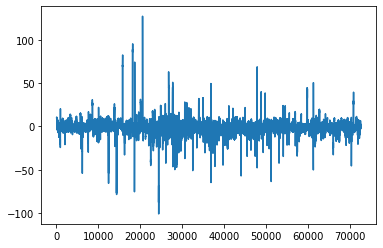

In [40]:
temp['train']['profit'].plot()

<AxesSubplot:>

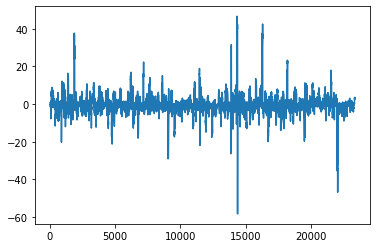

In [49]:
temp['test']['profit'].plot()

<AxesSubplot:>

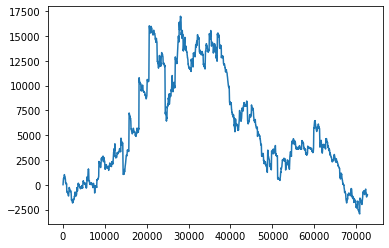

In [41]:
temp['train']['profit'].cumsum().plot()

<AxesSubplot:>

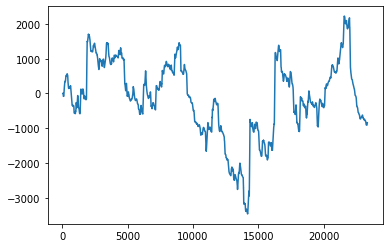

In [50]:
temp['test']['profit'].cumsum().plot()

In [42]:
sum(profits['train'])

-997.9355622927155

In [51]:
sum(profits['test'])

-840.6174946462096

In [44]:
(252 ** 0.5) * np.mean(profits['train']) / np.std(profits['train'])

-0.02514046842778499

In [52]:
(252 ** 0.5) * np.mean(profits['test']) / np.std(profits['test'])

-0.10683909062753291